# F1 data analysis notebook 
#### @kevinofsydney

Notes:
- The 'KeyError' is because the name of the column gets consumed when it is turned into an index 
- df = pd.merge(df,df2[['Key_Column','Target_Column']],on='Key_Column', how='left')
- RIC driverId is 817
- df.describe() is useful
- oddsportal.com
- race_df['name'].unique()

In [155]:
import pandas as pd
import numpy as np

In [156]:
# Load the files
cir_df = pd.read_csv('circuits_l.csv')
conresult_df = pd.read_csv('constructor_results_l.csv')
constanding_df = pd.read_csv('constructor_standings_l.csv')
con_df = pd.read_csv('constructors_l.csv')
driver_df = pd.read_csv('driver_l.csv')
laptime_df = pd.read_csv('lap_times_l.csv')
quali_df = pd.read_csv('qualifying_l.csv')
race_df = pd.read_csv('races_l.csv')
result_df = pd.read_csv('results_l.csv')
status_df = pd.read_csv('status_l.csv')

# Set the correct indices 
race_df['date'] = pd.to_datetime(race_df['date'], dayfirst=True)

# driver_df.set_index('driverId', inplace=True)
quali_df.set_index('qualifyId', inplace=True)
laptime_df.set_index('raceId', inplace=True)
race_df.set_index('date', inplace=True)
result_df.set_index('resultId', inplace=True)

# race_df.sort_values('raceId', inplace=True)
race_df.sort_index(inplace=True)

# Remove unnecessary columns
result_df = result_df.drop('number', axis=1)

In [189]:
driver_df.head(5)
quali_df.head(5)
result_df.head(5)

,raceId,driverId,constructorId,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
resultId,,,,,,,,,,,,,,,,
22130,900,3,131,3,1,1,1,25,57,32:58.7,5578710,19,1,01:32.5,206.436,1
22131,900,825,1,4,2,2,2,18,57,26.777,5605487,49,6,01:33.1,205.131,1
22132,900,18,1,10,3,3,3,15,57,30.027,5608737,39,5,01:32.9,205.46,1
22133,900,4,6,5,4,4,4,12,57,35.284,5613994,57,7,01:33.2,204.867,1
22134,900,822,3,15,5,5,5,10,57,47.639,5626349,56,3,01:32.6,206.128,1


In [158]:
%matplotlib inline
# race_df.plot()

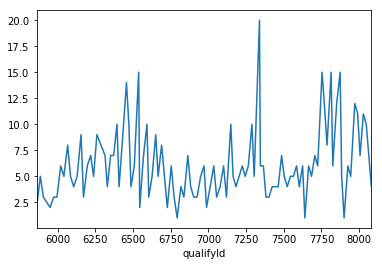

In [159]:
quali_df[ quali_df['driverId'] == 817]
quali_df[ quali_df['driverId'] == 817]['position'].plot()

In [168]:
# Find a driverId via their code
code = 'RAI'
did = driver_df[ driver_df['code'] == code]['driverId']
print("INFO: driverID for", code, "is:", int(did))
ex_result_df = result_df[ result_df['driverId'] == int(did) ]
# result_df.head(5)
### Return the result for a single driver
temp_df = pd.merge(driver_df[ ['driverId', 'code']], ex_result_df, on='driverId' )
temp_df.head(5)

### Return the results for all drivers 
# temp_df = pd.merge(driver_df[ ['driverId', 'code']], result_df, on='driverId' )
# temp_df.sort_values(by=['raceId', 'positionOrder']).head(50)
# temp_df.corr().head(5)

INFO: driverID for RAI is: 8


,driverId,code,raceId,constructorId,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,8,RAI,900,6,11,7,7,7,6,57,57.675,5636385,56,8,01:33.2,204.814,1
1,8,RAI,901,6,6,12,12,12,0,55,\N,\N,36,7,01:45.1,189.812,11
2,8,RAI,902,6,5,10,10,10,1,57,33.462,6016205,35,8,01:39.4,195.933,1
3,8,RAI,903,6,11,8,8,8,4,54,+1:16.335,5684673,34,8,01:42.3,191.824,1
4,8,RAI,904,6,6,7,7,7,6,65,\N,\N,53,11,01:30.6,185.007,11


In [164]:
result_df[ result_df['driverId'] == 817].head(5)

,raceId,driverId,constructorId,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
resultId,,,,,,,,,,,,,,,,
22151,900,817,9,2,\N,D,22,0,57,24.525,5603235,\N,0,\N,\N,2
22167,901,817,9,5,\N,R,16,0,49,\N,\N,48,5,01:44.7,190.635,39
22177,902,817,9,13,4,4,4,12,57,24.489,6007232,38,4,01:39.3,196.266,1
22199,903,817,9,2,4,4,4,12,54,27.136,5635474,39,3,01:41.5,193.387,1
22220,904,817,9,3,3,3,3,15,66,49.014,6114169,65,5,01:30.0,186.175,1


In [191]:
# Merging the quali, driver_details and results dataframes together
quali_rdf = quali_df[['raceId', 'driverId', 'q1', 'q2', 'q3']]
master = driver_df[['driverId', 'code']].merge(quali_rdf, how='inner', on=['driverId'])
master = quali_rdf.merge(result_df, how='inner', left_on=['raceId', 'driverId'], right_on=['raceId', 'driverId'])
master.sort_values(by=['raceId', 'positionOrder']).head(50)

,raceId,driverId,q1,q2,q3,constructorId,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
2,900,3,01:32.6,01:42.3,01:44.6,131,3,1,1,1,25,57,32:58.7,5578710,19,1,01:32.5,206.436,1
3,900,825,01:30.9,01:43.2,01:45.7,1,4,2,2,2,18,57,26.777,5605487,49,6,01:33.1,205.131,1
10,900,18,01:31.4,01:44.4,\N,1,10,3,3,3,15,57,30.027,5608737,39,5,01:32.9,205.46,1
4,900,4,01:31.4,01:42.8,01:45.8,6,5,4,4,4,12,57,35.284,5613994,57,7,01:33.2,204.867,1
9,900,822,01:31.6,01:43.9,01:48.1,3,15,5,5,5,10,57,47.639,5626349,56,3,01:32.6,206.128,1
6,900,807,01:33.9,01:43.7,01:46.0,10,7,6,6,6,8,57,50.718,5629428,56,2,01:32.6,206.235,1
11,900,8,01:32.4,01:44.5,\N,6,11,7,7,7,6,57,57.675,5636385,56,8,01:33.2,204.814,1
5,900,818,01:33.5,01:43.8,01:45.9,5,6,8,8,8,4,57,+1:00.441,5639151,56,10,01:33.7,203.763,1
7,900,826,01:33.8,01:44.3,01:47.4,5,8,9,9,9,2,57,+1:03.585,5642295,35,11,01:33.9,203.387,1
15,900,815,01:34.1,01:47.3,\N,10,16,10,10,10,1,57,+1:25.916,5664626,38,4,01:32.6,206.088,1
